# Road sign classification (Test)

## by Yasin Shafiei

### project detection:
This project will test the trained model to classify road signs.

### 1. Read and ready the test data

In [1]:
# import libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.utils.data as data
import time
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# defien the hyperparameters 
NUM_CLASSES = 43

In [3]:
# define the data transformation
data_transformation = transforms.Compose([transforms.Resize([112, 112]), transforms.ToTensor()])
# read the test data dir
test_data_dir = "data/Test"
# define the test dataset
test_dataset = torchvision.datasets.ImageFolder(root = test_data_dir, transform = data_transformation)
# define test loader
test_loader = data.DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [4]:
# read the labels (from the csv file)
data_frame = pd.read_csv("data/Test.csv")
# define the example number 
n_examples = len(data_frame)
# label list 
label_list = list(data_frame.ClassId)

In [5]:
# see the example number
print(f"Number of test examples: {n_examples}")

Number of test examples: 12630


So now we've done reading the data. Lets see the labels of the data

### 2. See data labels

In [6]:
# define a list for labels
labels = list()

# for each class, add i to the label
for i in range(NUM_CLASSES):
    labels.append(str(i))

# sort the labels
labels = sorted(labels)

# make [i] label and intiger
for i in range(NUM_CLASSES):
    labels[i] = int(labels[i])

In [7]:
# see the labels
print("Labels: ")
print("Actual labels \t==> Class in pytorch")
for i in range(NUM_CLASSES):
    print(f"\t{labels[i]}\t==> \t{i}")

Labels: 
Actual labels 	==> Class in pytorch
	0	==> 	0
	1	==> 	1
	10	==> 	2
	11	==> 	3
	12	==> 	4
	13	==> 	5
	14	==> 	6
	15	==> 	7
	16	==> 	8
	17	==> 	9
	18	==> 	10
	19	==> 	11
	2	==> 	12
	20	==> 	13
	21	==> 	14
	22	==> 	15
	23	==> 	16
	24	==> 	17
	25	==> 	18
	26	==> 	19
	27	==> 	20
	28	==> 	21
	29	==> 	22
	3	==> 	23
	30	==> 	24
	31	==> 	25
	32	==> 	26
	33	==> 	27
	34	==> 	28
	35	==> 	29
	36	==> 	30
	37	==> 	31
	38	==> 	32
	39	==> 	33
	4	==> 	34
	40	==> 	35
	41	==> 	36
	42	==> 	37
	5	==> 	38
	6	==> 	39
	7	==> 	40
	8	==> 	41
	9	==> 	42


We just saw the labels. So now we can start prediction...

###  3. Define and read the model

In [8]:
class Model(nn.Module):
    # __init__
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )
    
        # classifier (hidden layers and neurons)
        self.classifier = nn.Sequential(
            
            # hidden layer 1
            nn.Dropout(0.3),
            nn.Linear(512*7*7, 1024),
            nn.ReLU(inplace=True),
            
            # hidden layer 2
            nn.Dropout(0.3),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(inplace=True),
                        
    
            # output layer
            nn.Linear(512, output_dim)
            )
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

Now lets classify images:

In [9]:
# define the model directory
MODEL_DIR = "model/Yasin-model.pth"
# define the model
model = Model(NUM_CLASSES)
# load the model train
model.load_state_dict(torch.load(MODEL_DIR))
# make model to classify with CUDA (gpu)
model = model.cuda()

### Classify images

# define a list for y_prediction
y_prediction_list = list()
# define a variable for correct predictions
correct_prediction = 0

with torch.no_grad():
    
    # evaluate the model
    model.eval()
    
    # define i and set it to 0
    n_prediction = 0
    
    # for image and _ set image to a cuda variable 
    for image, _ in test_loader:
        # make image a CUDA variable
        image = image.cuda()
        
        # prediction
        prediction = model(image)
        # define y_prediction softmax
        y_prediction_softmax = torch.log_softmax(prediction[0], dim = 1)
        # define y prediction tags
        _, y_prediction_tags = torch.max(y_prediction_softmax, dim=1)
        y_prediction_tags = y_prediction_tags.cpu().numpy()
        
        # define y prediction
        y_prediction = y_prediction_tags[0]
        y_prediction = labels[y_prediction]
        
        # append the prediction to the y_prediction dictionary
        y_prediction_list.append(y_prediction)
        
        # if the prediction was true, add 1 to the true prediction
        if y_prediction == label_list[n_prediction]:
            correct_prediction += 1
        
        # add one to prediction counter
        n_prediction += 1
        

Now the model classified all images. Lets see the accuracy of the prediction 

In [10]:
# define variables which should be printed
correct_predictions = correct_prediction
incorrect_predictions = n_examples - correct_predictions
accuracy = correct_predictions / n_examples

print(f"Number true predictions: {correct_predictions}")
print(f"Number of incorrect predictiond: {incorrect_predictions}")
print(f"Prediction Accuracy: {round(accuracy, 4)}")
print("")
print(classification_report(label_list, y_prediction_list))

Number true predictions: 12124
Number of incorrect predictiond: 506
Prediction Accuracy: 0.9599

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        60
           1       0.95      0.97      0.96       720
           2       0.98      0.97      0.97       750
           3       0.95      0.97      0.96       450
           4       0.99      0.97      0.98       660
           5       0.95      0.99      0.97       630
           6       0.98      0.79      0.88       150
           7       0.97      0.97      0.97       450
           8       0.98      0.97      0.97       450
           9       0.97      1.00      0.98       480
          10       0.99      0.98      0.99       660
          11       0.95      0.98      0.97       420
          12       0.99      0.94      0.97       690
          13       0.99      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       1.00      0.99     

We've got a very good accuracy. The acc is around `96%` .
Now we should plot some graphs and then show the predictions

### 4. Show the confusion matrix

Draw the confusion matrix using the `confusion_matrix` function

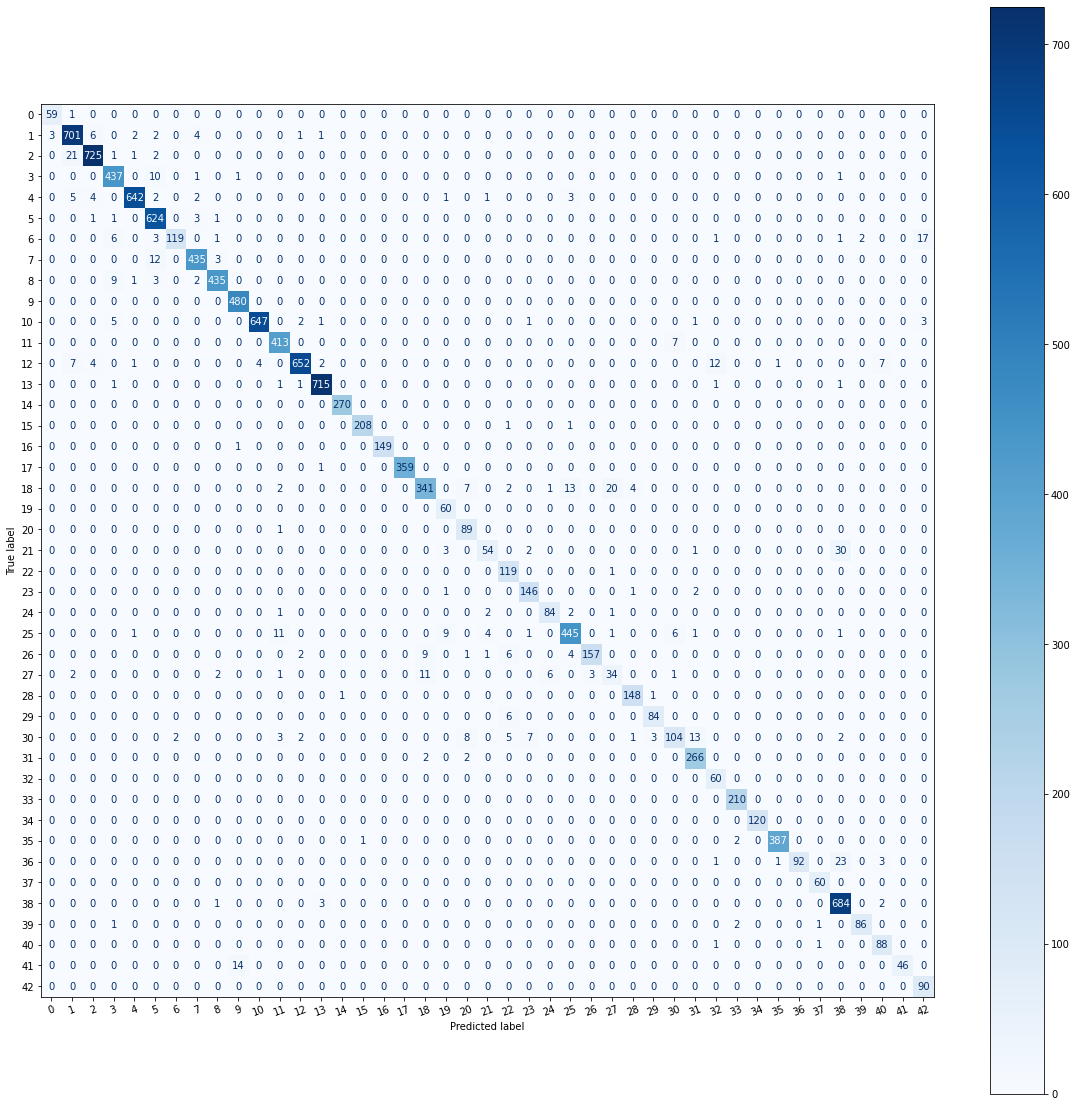

In [11]:
def plot_confusion_matrix(labels, pred_labels, classes):
    """
    This function will draw the confusion matrix
    """
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
labels_arr = range(0, NUM_CLASSES)
plot_confusion_matrix(label_list, y_prediction_list, labels_arr)

Now we saw the confusion matrix . Lets see some predictions in action...

### 5. See some predictinos

Display the first 60 predictions

In [12]:
# define a list for all labels
label_map = {
    '0': '20_speed',
    '1': '30_speed',
    '2': '50_speed',
    '3': '60_speed',
    '4': '70_speed',
    '5': '80_speed',
    '6': '80_lifted',
    '7': '100_speed',
    '8': '120_speed',
    '9': 'no_overtaking_general',
    '10': 'no_overtaking_trucks',
    '11': 'right_of_way_crossing',
    '12': 'right_of_way_general',
    '13': 'give_way',
    '14': 'stop',
    '15': 'no_way_general',
    '16': 'no_way_trucks',
    '17': 'no_way_one_way',
    '18': 'attention_general',
    '19': 'attention_left_turn',
    '20': 'attention_right_turn',
    '21': 'attention_curvy',
    '22': 'attention_bumpers',
    '23': 'attention_slippery',
    '24': 'attention_bottleneck',
    '25': 'attention_construction',
    '26': 'attention_traffic_light',
    '27': 'attention_pedestrian',
    '28': 'attention_children',
    '29': 'attention_bikes',
    '30': 'attention_snowflake',
    '31': 'attention_deer',
    '32': 'lifted_general',
    '33': 'turn_right',
    '34': 'turn_left',
    '35': 'turn_straight',
    '36': 'turn_straight_right',
    '37': 'turn_straight_left',
    '38': 'turn_right_down',
    '39': 'turn_left_down',
    '40': 'turn_circle',
    '41': 'lifted_no_overtaking_general',
    '42': 'lifted_no_overtaking_trucks'
}

# define values
values = label_map.values()
v = list(values)

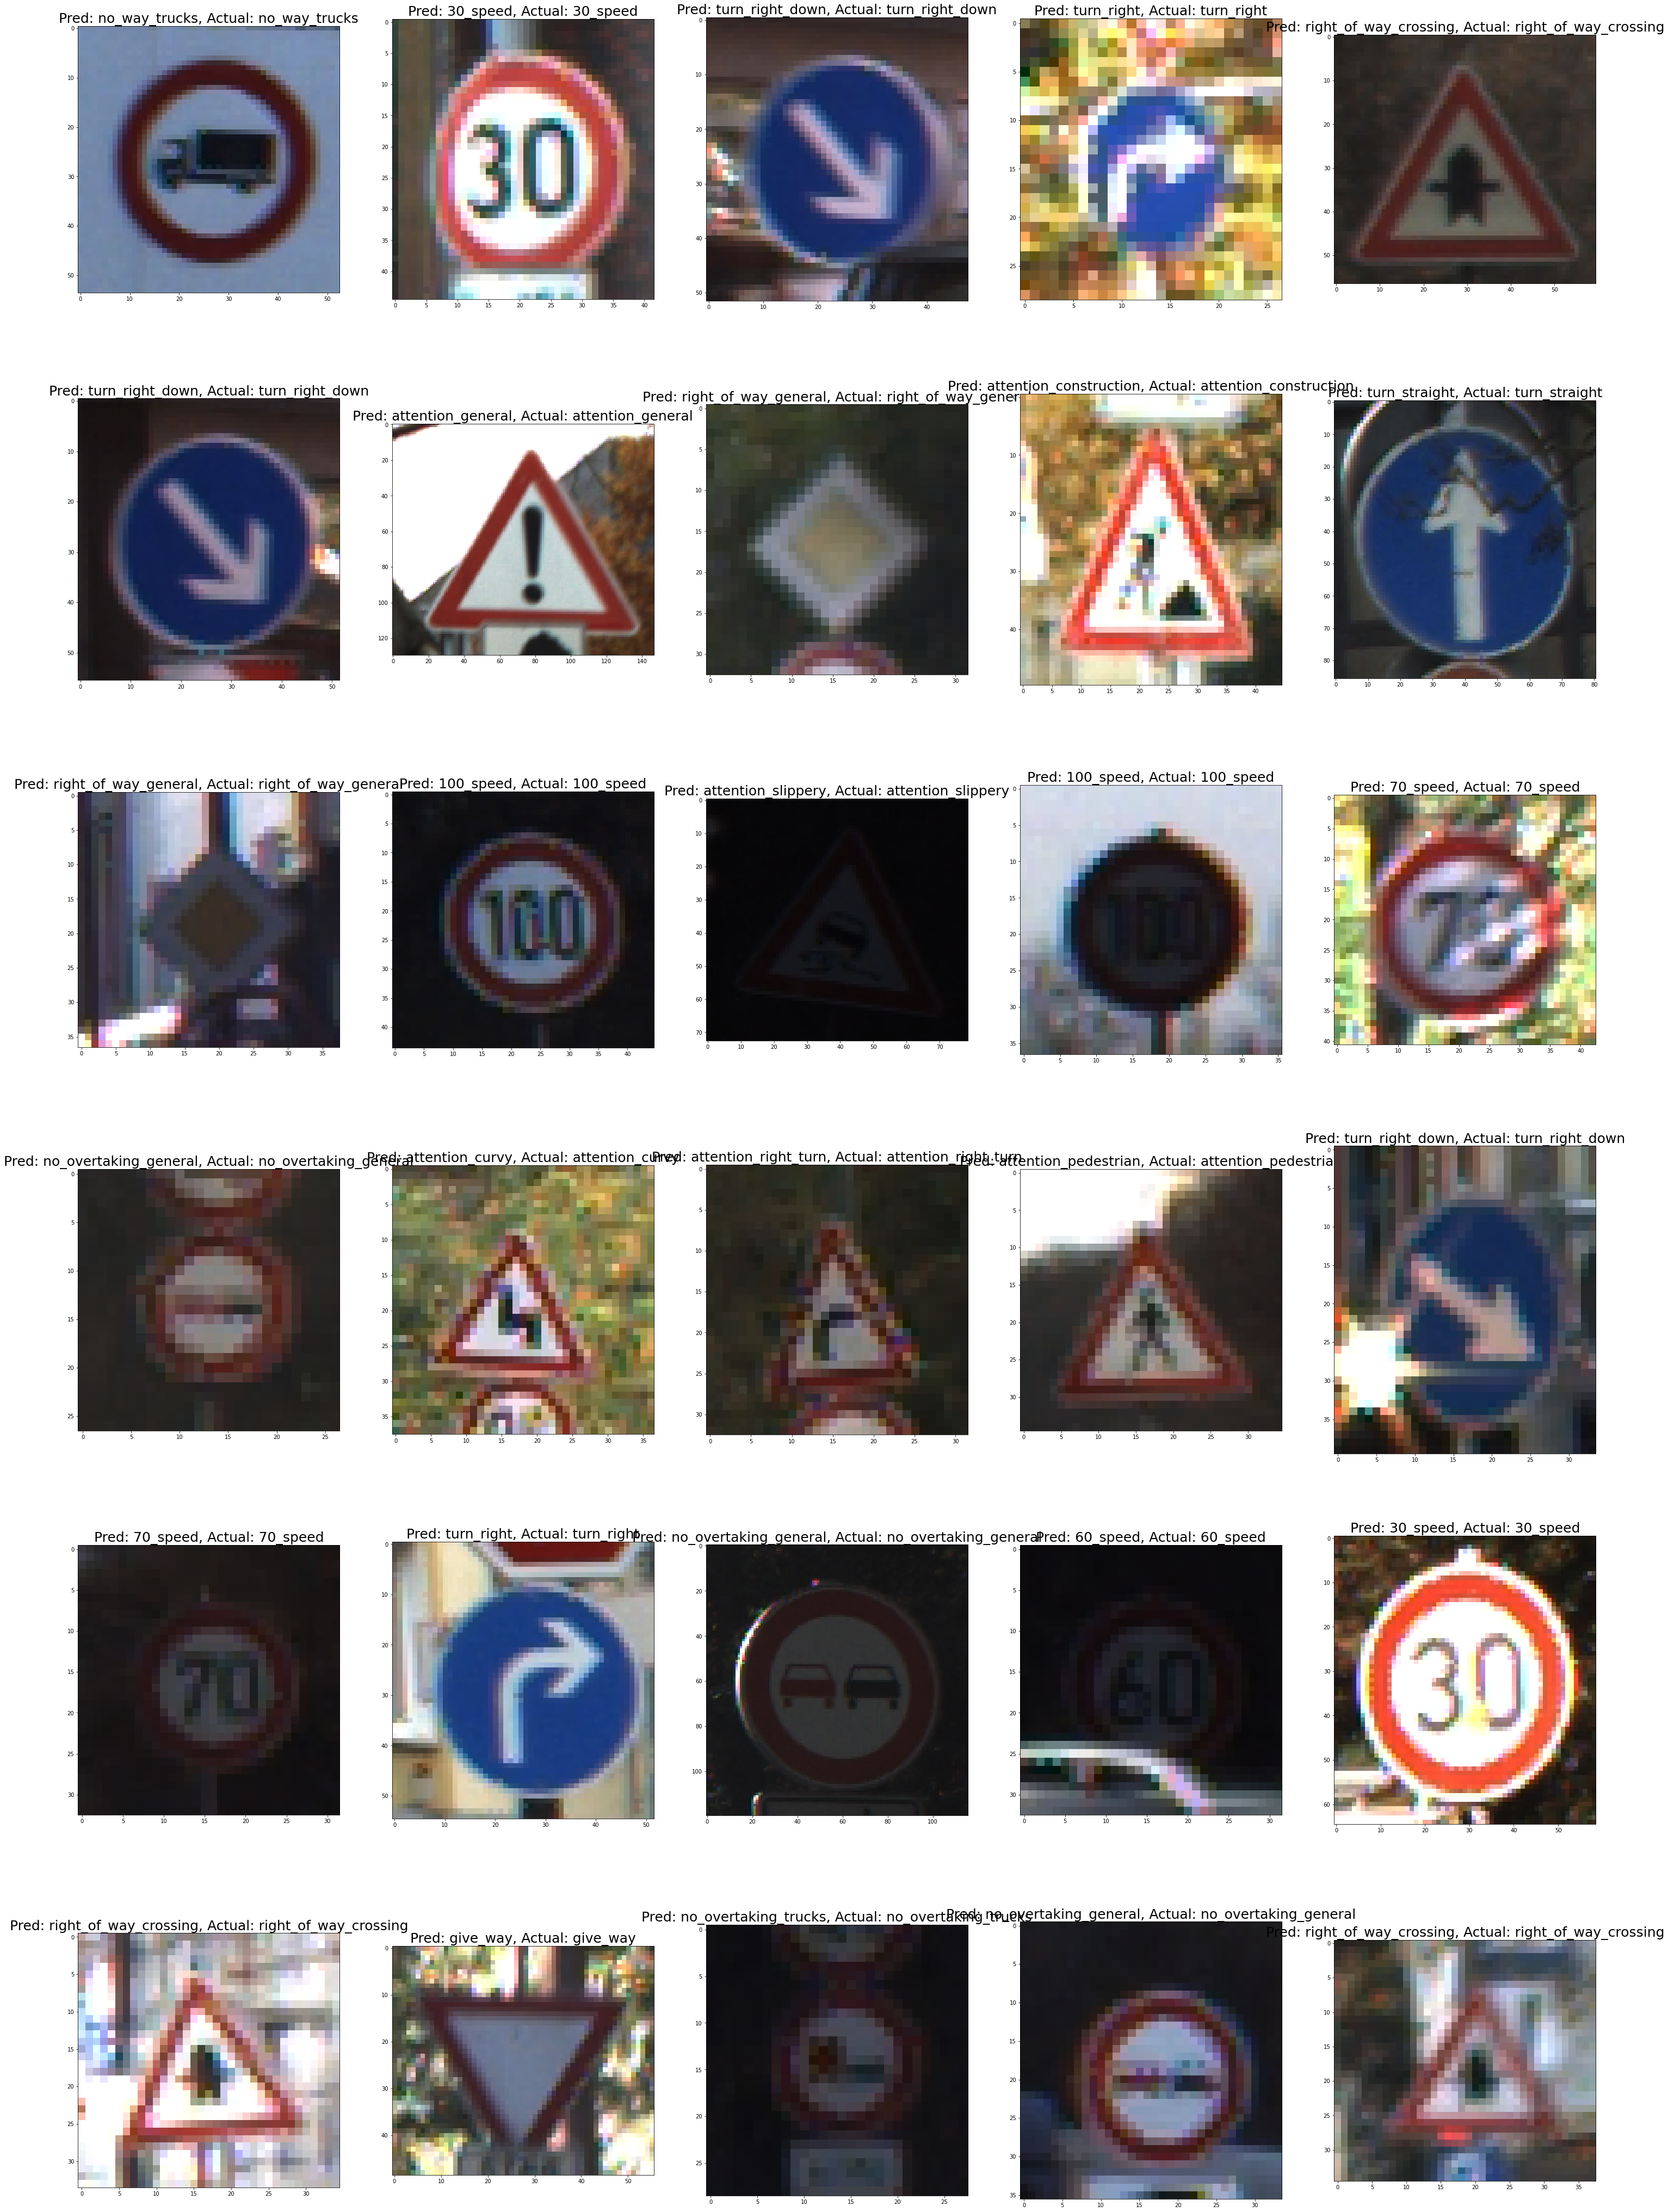

In [13]:
# define the figure and axis
fig, axs = plt.subplots(6,5,figsize=(50,75))
#fig.tight_layout(h_pad = 50)
for i in range(30):
    row = i // 5
    col = i % 5
    
    imgName = 'data/Test/' + data_frame.iloc[i].Path
    img = Image.open(imgName)
    axs[row, col].imshow(img)
    title = f"Pred: {v[y_prediction_list[i]]}, Actual: {v[label_list[i]]}"
    axs[row, col].set_title(title, fontsize=25)
    
plt.savefig("predictions.png", bbox_inches = 'tight', pad_inches=0.9)